In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import matplotlib.pyplot as plt
import warnings

## Gathering Data

In [2]:
enhanced_archive = pd.read_csv("twitter_archive_enhanced.csv")
enhanced_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [3]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open ('image_predictions.tsv','wb') as file:
    file.write(response.content)
predictions = pd.read_csv("image-predictions.tsv",sep='\t')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Working with Tweepy

In [4]:
consumer_key = '0e8XGgQLQFa0OBlgY6Vt2VGOO'
consumer_secret = 'Z8K8o4E9RqGdRfXCvYsqnYgf2Ua7BXzvHZqOsCNEhBBkIT7jHf'
access_token = '3052075171-gsOgxxg6YBnFFF8uA3dvkViLjfV8LuFl9xltQq1'
access_secret = '9kQcMRx6gW6ozQmSe3bWQV9a50zANsv3wfVaX3j0MpZxK'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [5]:
tweets_with_errors = []
no_err_tweets = []
for tweet_id in enhanced_archive['tweet_id']:
    try:
        #After testing this a bit, there was a problem with overloading the tweepy API, so we need to add some limits
        temp_tweet_json = api.get_status(tweet_id, tweet_mode="extended", wait_on_rate_limit = True, wait_on_rate_limit_notify = True)._json
        retweet_count = temp_tweet_json['retweet_count']
        tweet_favorite_count = temp_tweet_json['favorite_count']
        follower_count = temp_tweet_json['user']['followers_count']
        user_favorite_count = temp_tweet_json['user']['favourites_count']
        creation_date = temp_tweet_json['created_at']
        no_err_tweets.append({"tweet_id": int(tweet_id),
                              "retweets": int(retweet_count),
                              "tweet_favorites": int(tweet_favorite_count),
                              "user_followers": int(follower_count),
                              "user_favorites": int(user_favorite_count),
                              "creation_date": pd.to_datetime(creation_date)})
    except Exception as e:
        print(str(tweet_id)+"-"+ str(e))
        tweets_with_errors.append(tweet_id)

888202515573088257-[{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921-[{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937-[{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745-[{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329-[{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744-[{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320-[{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130-[{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560-[{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705-[{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984-[{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648-[{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778-[{'code': 144, 'message': 'No sta

In [6]:
#Now lets test to see how many tweets we had with errors and how many tweets didn't have errors
print("Tweets with errors:", len(tweets_with_errors))
print("Tweets without errors:", len(no_err_tweets))

Tweets with errors: 23
Tweets without errors: 2333


Running through, we ended up with 2333 tweets without errors so those tweets are usable for investigation.


In [7]:
#Create a dataframe so that we can save the dataframe as the tweet_json.txt file
temp_df = pd.DataFrame(no_err_tweets, columns=['tweet_id','retweets','tweet_favorites','user_followers','user_favorites','creation_date'])
temp_df.to_csv('tweet_json.txt', encoding='utf-8',index=False)

In [8]:
#Let's visualize/look at the dataset now
tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
tweet_data.head()

,tweet_id,retweets,tweet_favorites,user_followers,user_favorites,creation_date
0,892420643555336193,7949,37164,8336977,143177,2017-08-01 16:23:56
1,892177421306343426,5903,31967,8336977,143177,2017-08-01 00:17:27
2,891815181378084864,3903,24070,8336977,143177,2017-07-31 00:18:03
3,891689557279858688,8103,40483,8336977,143177,2017-07-30 15:58:51
4,891327558926688256,8786,38709,8336977,143177,2017-07-29 16:00:24


## Assessing

In [9]:
enhanced_archive.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
enhanced_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
enhanced_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
predictions.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [13]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
#One variable that we might want to check out is how the dogs are rated
print("Rating Numerators:\n",enhanced_archive['rating_numerator'].value_counts())
print("Rating Denominators:\n",enhanced_archive['rating_denominator'].value_counts())

Rating Numerators:
 12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64
Rating Denominators:
 10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64


In [15]:
#Check for any duplicates
enhanced_archive.duplicated().sum()

0

Quality Issues that need to be fixed:
1. We will assume that any numerator over the value of 20 is unreliable. This could very much result in losing a couple tweets that were fine to work with, but the majority of rating numerators over 20 are unrealiable

2. We will get rid of any rows that don't have a denominator of 10. We want to keep the ratings out of 10 if possible. 

3. We will get rid of any rows that have "None" as the name. It is, again, possible that we lose tweets are fine to work with, but the majority of rows that have "None" under name are tweets that are not relavent to this project.

4. Renaming column names to be more accurate and more appropriate.

5. Adjusting data types for all date/timestamp columns. 

6. Capitalize the first letter of p1 in predictions.

7. We will get rid of any rows that have "False" as p1_dog (This will be done before merging).

8. We will get rid of rows that have a value in retweeted_status_id and in_reply_to_status_id, as it means this is a retweet. Then proceed to remove the retweeted_status columns as well as the reply columns.

Tidiness Issues that need to be fixed:
1. We will get rid of columns that say "doggo", "floofer", "pupper", and "puppo", then create just one column called "stage_of_dog", which will hold whether or not the dog was either of these four stages.

2. We will merge the prediction dataframe (by tweet_id) to be able to see what breed of dog the tweet shows.

In [16]:
#First set up copies of each data frame
enhanced_archive_copy = enhanced_archive.copy()
predictions_copy = predictions.copy()
tweet_data_copy = tweet_data.copy()

In [17]:
#Define
#Quality Issue 1: We will assume that any numerator over the value of 20 is unreliable. 

#Code
ratings = enhanced_archive_copy.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
enhanced_archive_copy.rating_numerator = ratings
enhanced_archive_copy.head()
enhanced_archive_copy.rating_numerator = enhanced_archive_copy.rating_numerator.replace({'007':'7'})
enhanced_archive_copy['rating_numerator'] = enhanced_archive_copy['rating_numerator'].astype('float64')
enhanced_archive_copy.drop(enhanced_archive_copy[enhanced_archive_copy.rating_numerator > 20].index, inplace=True)

#Test
enhanced_archive_copy['rating_numerator'].value_counts()

12.00    558
11.00    464
10.00    461
13.00    351
9.00     158
8.00     102
7.00      55
14.00     54
5.00      35
6.00      32
3.00      19
4.00      17
1.00       9
2.00       9
15.00      2
9.75       2
0.00       2
9.50       1
17.00      1
13.50      1
11.27      1
11.26      1
20.00      1
Name: rating_numerator, dtype: int64

In [18]:
#Define
#Quality Issue 2: We will get rid of any rows that don't have a denominator of 10. 

#Code
enhanced_archive_copy.drop(enhanced_archive_copy[enhanced_archive_copy.rating_denominator != 10].index, inplace=True)
enhanced_archive_copy['rating_denominator'] = enhanced_archive_copy['rating_denominator'].astype('float64')

#Test
enhanced_archive_copy['rating_denominator'].value_counts()

10.0    2328
Name: rating_denominator, dtype: int64

In [19]:
#Define
#Quality Issue 3: We will get rid of any rows that have "None" as the name. 


#Code
#This cleaning process was found from a project from the past, but it was something that was useful to use
enhanced_archive_copy['name'].replace('the', 'None', inplace=True)
enhanced_archive_copy['name'].replace("light",'None', inplace=True)
enhanced_archive_copy['name'].replace("life",'None', inplace=True)
enhanced_archive_copy['name'].replace("an",'None', inplace=True)
enhanced_archive_copy['name'].replace("a",'None', inplace=True)
enhanced_archive_copy['name'].replace("by",'None', inplace=True)
enhanced_archive_copy['name'].replace("actually",'None', inplace=True)
enhanced_archive_copy['name'].replace("just",'None', inplace=True)
enhanced_archive_copy['name'].replace("getting",'None', inplace=True) 
enhanced_archive_copy['name'].replace("infuriating",'None', inplace=True) 
enhanced_archive_copy['name'].replace("old",'None', inplace=True) 
enhanced_archive_copy['name'].replace("all",'None', inplace=True) 
enhanced_archive_copy['name'].replace("this",'None', inplace=True) 
enhanced_archive_copy['name'].replace("very",'None', inplace=True) 
enhanced_archive_copy['name'].replace("mad",'None', inplace=True) 
enhanced_archive_copy['name'].replace("not",'None', inplace=True)
enhanced_archive_copy['name'].replace("one",'None', inplace=True)
enhanced_archive_copy['name'].replace("my",'None', inplace=True)
enhanced_archive_copy['name'].replace("O","O'Malley", inplace=True)
enhanced_archive_copy['name'].replace("quite","None", inplace=True)
enhanced_archive_copy['name'].replace("such","None", inplace=True)
#This is where I got this bit from
#https://github.com/RedRock42/Udacity-Nanodegree-Portfolio/blob/master/P4.Wrangling%20%26%20Analyzing%20Twitter%20Data/Wrangle%20Act.ipynb
enhanced_archive_copy['name'].replace("incredibly","None", inplace=True)

enhanced_archive_copy.drop(enhanced_archive_copy[enhanced_archive_copy.name == "None"].index, inplace=True)

#Test
enhanced_archive_copy['name'].value_counts()

Charlie      12
Cooper       11
Lucy         11
Oliver       11
Lola         10
Penny        10
Tucker       10
Bo            9
Winston       9
Sadie         8
Daisy         7
Toby          7
Buddy         7
Bailey        7
Rusty         6
Bella         6
Oscar         6
Milo          6
Leo           6
Scout         6
Dave          6
Jack          6
Stanley       6
Jax           6
Koda          6
George        5
Phil          5
Bentley       5
Larry         5
Oakley        5
             ..
Hubertson     1
Buckley       1
Flurpson      1
William       1
Strudel       1
Poppy         1
Laela         1
Angel         1
Crouton       1
Fido          1
Bruno         1
Mingus        1
Bonaparte     1
Richie        1
Ole           1
Tuco          1
Cedrick       1
Pinot         1
Blanket       1
Covach        1
Mutt          1
Striker       1
Ace           1
Spark         1
Genevieve     1
Kobe          1
Willie        1
Sweet         1
DayZ          1
Tango         1
Name: name, Length: 933,

In [20]:
#Define
#Quality Issue 4: Renaming column names to be more accurate and more appropriate.

#Code
predictions_copy.rename(columns={"p1":"first_prediction", "p1_conf":"first_prediction_confidence", "p1_dog":"first_prediction_is_a_dog","p2":"second_prediction", "p2_conf":"second_prediction_confidence", "p2_dog":"second_prediction_is_a_dog","p3":"third_prediction", "p3_conf":"third_prediction_confidence", "p3_dog":"third_prediction_is_a_dog"},inplace=True)
enhanced_archive_copy.rename(columns={"timestamp":"timestamp_of_tweet","text":"text_of_tweet","source":"source_of_tweet"},inplace=True)

#Test
enhanced_archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_of_tweet,source_of_tweet,text_of_tweet,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None


In [21]:
#Define
#Quality Issue 5: Adjusting data types for all date/timestamp columns.

#Code
enhanced_archive_copy['timestamp_of_tweet'] = enhanced_archive_copy['timestamp_of_tweet'].astype('datetime64[ns]')

#Test
enhanced_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1502 entries, 0 to 2325
Data columns (total 17 columns):
tweet_id                      1502 non-null int64
in_reply_to_status_id         1 non-null float64
in_reply_to_user_id           1 non-null float64
timestamp_of_tweet            1502 non-null datetime64[ns]
source_of_tweet               1502 non-null object
text_of_tweet                 1502 non-null object
retweeted_status_id           111 non-null float64
retweeted_status_user_id      111 non-null float64
retweeted_status_timestamp    111 non-null object
expanded_urls                 1502 non-null object
rating_numerator              1502 non-null float64
rating_denominator            1502 non-null float64
name                          1502 non-null object
doggo                         1502 non-null object
floofer                       1502 non-null object
pupper                        1502 non-null object
puppo                         1502 non-null object
dtypes: datetime64[ns]

In [22]:
#Define
#Quality Issue 6: Capitalize the first letter of p1 in predictions.

#Code
temp = []
for temp1 in predictions_copy['first_prediction']:
    temp1 = temp1[0].upper()+temp1[1:]
    temp.append(temp1)
predictions_copy['first_prediction'] = temp

#Test
predictions_copy.head()

,tweet_id,jpg_url,img_num,first_prediction,first_prediction_confidence,first_prediction_is_a_dog,second_prediction,second_prediction_confidence,second_prediction_is_a_dog,third_prediction,third_prediction_confidence,third_prediction_is_a_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [23]:
#Define
#Quality Issue 7: We will get rid of any rows that have "False" as p1_dog (This will be done before merging).

#Code
predictions_copy.drop(predictions_copy[predictions_copy.first_prediction_is_a_dog == False].index, inplace=True)

#Test
predictions_copy['first_prediction_is_a_dog'].value_counts()

True    1532
Name: first_prediction_is_a_dog, dtype: int64

In [24]:
#Define
#Quality Issue 8: We will get rid of rows that have a value in retweeted_status_id and in_reply_to_status_id, as it means this is a retweet. Then proceed to remove the retweeted_status columns and reply columns.

#Code
enhanced_archive_copy.drop(enhanced_archive_copy[enhanced_archive_copy.retweeted_status_id.notnull()].index, inplace=True)
enhanced_archive_copy['retweeted_status_id'].value_counts()
enhanced_archive_copy.drop(enhanced_archive_copy[enhanced_archive_copy.in_reply_to_status_id.notnull()].index, inplace=True)
enhanced_archive_copy['in_reply_to_status_id'].value_counts()
enhanced_archive_copy = enhanced_archive_copy.drop(columns={'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'})

#Test
enhanced_archive_copy.head()

,tweet_id,timestamp_of_tweet,source_of_tweet,text_of_tweet,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None


In [25]:
#Define
#Tidiness Issue 1: We will get rid of columns that say "doggo", "floofer", "pupper", and "puppo", then create just one column called "stage_of_dog", which will hold whether or not the dog was either of these four stages.

#Code
enhanced_archive_copy.doggo.replace('None', '', inplace=True)
enhanced_archive_copy.floofer.replace('None', '', inplace=True)
enhanced_archive_copy.pupper.replace('None', '', inplace=True)
enhanced_archive_copy.puppo.replace('None', '', inplace=True)
enhanced_archive_copy.groupby(['doggo','floofer', 'pupper', 'puppo']).size().reset_index().rename(columns={0: "count"})
enhanced_archive_copy['stage'] = enhanced_archive_copy.doggo + enhanced_archive_copy.floofer + enhanced_archive_copy.pupper + enhanced_archive_copy.puppo
enhanced_archive_copy.loc[enhanced_archive_copy.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
enhanced_archive_copy.loc[enhanced_archive_copy.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
enhanced_archive_copy.loc[enhanced_archive_copy.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

#enhanced_archive_copy = enhanced_archive_copy.reset_index()
#del enhanced_archive_copy['index']
#temp_stage = []
#for temp in range(0,len(enhanced_archive_copy)):
    #if enhanced_archive_copy.loc[temp, 'doggo'] == 'doggo':
        #temp_stage.append('doggo')
    #elif enhanced_archive_copy.loc[temp, 'floofer'] == 'floofer':
        #temp_stage.append('floofer')
    #elif enhanced_archive_copy.loc[temp, 'pupper'] == 'pupper':
        #temp_stage.append('pupper')
    #elif enhanced_archive_copy.loc[temp, 'puppo'] == 'puppo':
        #temp_stage.append('puppo')
    #else:
        #temp_stage.append('None')
#enhanced_archive_copy['stage_of_dog'] = temp_stage
enhanced_archive_copy = enhanced_archive_copy.drop(columns={'doggo','floofer','pupper','puppo'})

#Test
enhanced_archive_copy.head(50)


,tweet_id,timestamp_of_tweet,source_of_tweet,text_of_tweet,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo
10,890006608113172480,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13.0,10.0,Koda,
11,889880896479866881,2017-07-25 16:11:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,https://twitter.com/dog_rates/status/889880896...,13.0,10.0,Bruno,


In [26]:
#Define
#Tidiness Issue 2: We will merge the prediction dataframe (by tweet_id) to be able to see what breed of dog the tweet shows.

#Code
final_enhanced_archive = pd.merge(enhanced_archive_copy, predictions_copy, left_on='tweet_id', right_on='tweet_id')

#Test
final_enhanced_archive.head(20)

,tweet_id,timestamp_of_tweet,source_of_tweet,text_of_tweet,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,first_prediction,first_prediction_confidence,first_prediction_is_a_dog,second_prediction,second_prediction_confidence,second_prediction_is_a_dog,third_prediction,third_prediction_confidence,third_prediction_is_a_dog
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
3,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
4,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
5,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
6,890006608113172480,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13.0,10.0,Koda,,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
7,889880896479866881,2017-07-25 16:11:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,https://twitter.com/dog_rates/status/889880896...,13.0,10.0,Bruno,,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog,0.377417,True,Labrador_retriever,0.151317,True,muzzle,0.082981,False
8,889638837579907072,2017-07-25 00:10:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Ted. He does his best. Sometimes that'...,https://twitter.com/dog_rates/status/889638837...,12.0,10.0,Ted,,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True
9,889531135344209921,2017-07-24 17:02:04,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,https://twitter.com/dog_rates/status/889531135...,13.0,10.0,Stuart,puppo,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1,Golden_retriever,0.953442,True,Labrador_retriever,0.013834,True,redbone,0.007958,True


In [27]:
#Time to save final_enhanced_archive into a final csv
final_enhanced_archive.to_csv('twitter_archive_master.csv')

## Insights and Visualization

In [28]:
#Let's take a look at what the most common rating for a dog was
final_enhanced_archive['rating_numerator'].value_counts()

12.00    283
11.00    237
10.00    210
13.00    154
9.00      73
8.00      41
7.00      16
14.00     11
6.00       8
5.00       3
3.00       3
11.27      1
2.00       1
4.00       1
9.75       1
13.50      1
Name: rating_numerator, dtype: int64

Text(0.5,1,'Frequency of ratings for dogs')

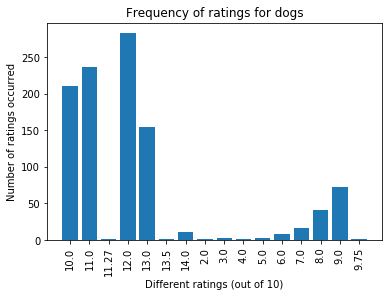

In [29]:
#Let's visualize this
rating_array = [1,3,1,3,8,16,41,73,1,210,237,1,283,154,1,11]
different_ratings = ['2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','9.75','10.0','11.0','11.27','12.0','13.0','13.5','14.0']

x = different_ratings
y = rating_array
plt.bar(x,y)
plt.xlabel('Different ratings (out of 10)')
plt.ylabel('Number of ratings occurred')
plt.xticks(rotation='vertical')
plt.title('Frequency of ratings for dogs')


Looking at this visualization, it seems like an 12/10 was the most frequently occurring rating given to dogs on WeRateDogs.

In [30]:
final_enhanced_archive['stage'].value_counts()

                 910
pupper            83
doggo             29
puppo             14
floofer            5
doggo, pupper      3
Name: stage, dtype: int64

In [31]:
final_enhanced_archive['first_prediction'].value_counts()

Golden_retriever                  91
Pembroke                          64
Labrador_retriever                64
Chihuahua                         59
Pug                               39
Chow                              31
Toy_poodle                        28
Pomeranian                        26
Samoyed                           23
Malamute                          22
French_bulldog                    22
Cocker_spaniel                    19
Siberian_husky                    18
Staffordshire_bullterrier         16
Chesapeake_Bay_retriever          16
Miniature_pinscher                16
Shih-Tzu                          15
Shetland_sheepdog                 14
German_shepherd                   14
Cardigan                          14
Beagle                            13
Eskimo_dog                        12
Italian_greyhound                 11
Pekinese                          11
Vizsla                            10
Basset                            10
Old_English_sheepdog              10
A

In [32]:
final_enhanced_archive['first_prediction_confidence'].describe()

count    1044.000000
mean        0.616923
std         0.266412
min         0.044333
25%         0.383992
50%         0.616923
75%         0.873385
max         0.999953
Name: first_prediction_confidence, dtype: float64

In [33]:
final_enhanced_archive['name'].value_counts()

Charlie      10
Cooper       10
Oliver        9
Lucy          8
Tucker        8
Sadie         7
Daisy         7
Penny         7
Jax           6
Koda          6
Winston       6
Toby          5
Bo            5
Rusty         5
Leo           5
Stanley       5
Bella         5
Scooter       4
Maggie        4
Finn          4
Dave          4
Dexter        4
Brody         4
Louis         4
Bear          4
Larry         4
Reggie        4
Cassie        4
Oscar         4
Gus           4
             ..
Alfy          1
Tebow         1
Claude        1
Halo          1
Sundance      1
Birf          1
Clybe         1
Gidget        1
Cannon        1
Berkeley      1
Alejandro     1
Smokey        1
Sephie        1
Taz           1
Sierra        1
Lillie        1
Liam          1
Grizz         1
Rilo          1
Striker       1
Stormy        1
Scott         1
Sobe          1
Piper         1
Zeus          1
Doug          1
Timison       1
Dido          1
Juckson       1
Ralph         1
Name: name, Length: 744,

Some insights:
1. When a dog had a stage listed, pupper was the stage that occurred the most.
2. Based off of just the first predictions of what breed the dog was, a golden retriever was the most frequently occuring.
3. The mean for confidence in first predictions was around 62%, which was the median confidence as well. The maximum confidence was as high as 99.99%, so almost 100%, while the minimum confidence was as low as 4.4%.
4. A fun fact and insight was that the most commonly occuring names for dogs were Cooper and Charlie.